In [1]:
try:
  from ajax import Prior, Likelihood, Variational, ADVI
except:
  %pip install -qq git+https://github.com/patel-zeel/ajax.git
  from ajax import Prior, Likelihood, Variational, ADVI

try:
  import optax
except:
  %pip install -qq optax
  import optax

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
from ajax.utils import fill_params
import jax
import matplotlib.pyplot as plt
import pickle
tfd = tfp.distributions
tfb = tfp.bijectors

2022-06-12 13:51:53.551684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
with open("../data/coin_toss",'rb') as f:
    data = pickle.load(f)
data

{'samples': array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1], dtype=int32),
 'prior': {'alpha': 10, 'beta': 15}}

In [3]:
dataset = data['samples']
alpha_param = data['prior'] ['alpha']
beta_param = data['prior']['beta']

In [4]:
prior = Prior(
    distributions = {
        "theta" : tfd.Beta(alpha_param, beta_param)
        }
    )

In [5]:
def link_function(samples):
  probs = samples["theta"]
  return {"probs" : probs}

In [6]:
likelihood = Likelihood(tfd.Bernoulli, link_function)

In [7]:
variational = Variational(
    prior=prior,
    bijectors={"theta":tfb.Sigmoid()},
    vi_type="full_rank"
)

In [8]:
advi = ADVI(prior, likelihood, variational, dataset)

In [9]:
params = variational.get_params()

In [10]:
tx = optax.adam(learning_rate=0.1)
state = tx.init(params)
value_and_grad_fun = jax.jit(jax.value_and_grad(advi.loss))

In [11]:
def update_func(carry,x):
  params = carry['params']
  state = carry['state']
  seed = carry['seed']
  seed = jax.random.split(seed, 1)[0]
  loss, grads = value_and_grad_fun(params, seed = seed)
  updates, state = tx.update(grads, state)
  params = optax.apply_updates(params, updates)
  carry = {'params':params, 'state':state, 'seed':seed}
  return carry, loss

In [12]:
carry = {'params':params, 'state': state,'seed':jax.random.PRNGKey(10)}#key value matters keep it 10 :(
carry,loss = jax.lax.scan(update_func, carry,xs = None,length= 50) 
loss

DeviceArray([10.058517 , 16.113482 ,  6.9468374, 13.484032 ,  7.629686 ,
              7.020435 ,  6.9728394,  8.745751 ,  8.365893 ,  7.649653 ,
              6.921013 ,  7.7824326,  7.522305 ,  8.534044 ,  7.358736 ,
              7.980904 ,  7.944159 ,  7.7575483,  7.489364 ,  7.49482  ,
              7.182612 ,  7.82884  ,  7.843391 ,  7.5552077,  7.91261  ,
              7.8136683,  8.023399 ,  7.9987373,  7.66147  ,  7.0872345,
              7.945277 ,  7.942891 ,  7.7062063,  7.8023224,  7.841023 ,
              7.667099 ,  7.588679 ,  7.4945555,  7.921564 ,  8.338562 ,
              7.803941 ,  7.715846 ,  8.002228 ,  7.9199047,  7.6822696,
              7.6283045,  7.7069073,  7.7482386,  7.6718607,  7.7961497],            dtype=float32)

In [13]:
keys = jax.random.PRNGKey(1)
variational.set_params(carry['params'])
sample = variational.sample(seed = keys, sample_shape = (19000,))

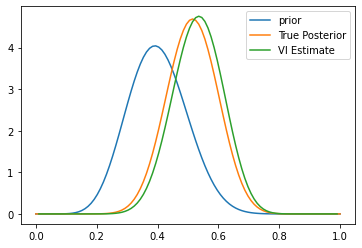

In [14]:
beta_dist_one = tfd.Beta(alpha_param, beta_param)
x = jnp.linspace(0,1,100)
plt.plot(x,beta_dist_one.prob(x),label="prior")
one= jnp.sum(dataset==1).astype('float32')
zero= jnp.sum(dataset==0).astype('float32')
beta_dist = tfd.Beta(alpha_param+one, beta_param+zero)
post_pdf = beta_dist.prob(x)
plt.plot(x,post_pdf,label="True Posterior")
di = {"theta":x}
plt.plot(x,jnp.exp(variational.log_prob(di)),label = "VI Estimate")
plt.legend()
plt.savefig("coin_toss_fig")

In [16]:
with open("results/coin_toss_VI_Ajax_result",'wb') as f:
    pickle.dump(variational, f,protocol = 1)